# Diabetes Mellitus API Predictions - Export to DataFrame

This notebook demonstrates how to:
1. Connect to the FastAPI server
2. Make predictions for single and multiple patients
3. Export results to pandas DataFrame
4. Save results to CSV files

**Prerequisites:** Make sure the API is running:
```bash
uvicorn api_fastapi:app --reload --port 8000
```

## 1. Setup and Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime

# API configuration
API_URL = "http://localhost:8000"

print("✅ Imports successful")

✅ Imports successful


## 2. Check API Health

In [2]:
def check_api_status():
    """Check if API is running and healthy"""
    try:
        response = requests.get(f"{API_URL}/health", timeout=5)
        if response.status_code == 200:
            health_data = response.json()
            print("✅ API is healthy and ready!")
            print(f"   Status: {health_data['status']}")
            print(f"   Models loaded: {health_data['models_loaded']}")
            return True
        else:
            print(f"⚠️  API returned status code: {response.status_code}")
            return False
    except requests.exceptions.ConnectionError:
        print("❌ Cannot connect to API. Make sure it's running on", API_URL)
        print("   Start with: uvicorn api_fastapi:app --reload --port 8000")
        return False
    except Exception as e:
        print(f"❌ Error: {e}")
        return False

# Check API status
api_ready = check_api_status()

✅ API is healthy and ready!
   Status: healthy
   Models loaded: {'logistic_regression': True, 'random_forest': True}


## 3. Define Sample Patient Data

In [3]:
# Create sample patients DataFrame
patients_data = [
    {
        "patient_id": "P001",
        "name": "Healthy Adult",
        "age": 45,
        "height": 175,
        "weight": 70,
        "aids": 0,
        "cirrhosis": 0,
        "hepatic_failure": 0,
        "immunosuppression": 0,
        "leukemia": 0,
        "lymphoma": 0,
        "solid_tumor_with_metastasis": 0
    },
    {
        "patient_id": "P002",
        "name": "Elderly Patient",
        "age": 72,
        "height": 168,
        "weight": 85,
        "aids": 0,
        "cirrhosis": 1,
        "hepatic_failure": 0,
        "immunosuppression": 0,
        "leukemia": 0,
        "lymphoma": 0,
        "solid_tumor_with_metastasis": 0
    },
    {
        "patient_id": "P003",
        "name": "High Risk Patient",
        "age": 68,
        "height": 165,
        "weight": 90,
        "aids": 0,
        "cirrhosis": 1,
        "hepatic_failure": 0,
        "immunosuppression": 1,
        "leukemia": 0,
        "lymphoma": 0,
        "solid_tumor_with_metastasis": 1
    },
    {
        "patient_id": "P004",
        "name": "Young Adult",
        "age": 28,
        "height": 170,
        "weight": 65,
        "aids": 0,
        "cirrhosis": 0,
        "hepatic_failure": 0,
        "immunosuppression": 0,
        "leukemia": 0,
        "lymphoma": 0,
        "solid_tumor_with_metastasis": 0
    },
    {
        "patient_id": "P005",
        "name": "Middle Age with Comorbidity",
        "age": 55,
        "height": 172,
        "weight": 82,
        "aids": 0,
        "cirrhosis": 0,
        "hepatic_failure": 0,
        "immunosuppression": 1,
        "leukemia": 0,
        "lymphoma": 0,
        "solid_tumor_with_metastasis": 0
    }
]

# Create DataFrame
df_patients = pd.DataFrame(patients_data)
print(f"Created {len(df_patients)} sample patients\n")
df_patients

Created 5 sample patients



,patient_id,name,age,height,weight,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,P001,Healthy Adult,45,175,70,0,0,0,0,0,0,0
1,P002,Elderly Patient,72,168,85,0,1,0,0,0,0,0
2,P003,High Risk Patient,68,165,90,0,1,0,1,0,0,1
3,P004,Young Adult,28,170,65,0,0,0,0,0,0,0
4,P005,Middle Age with Comorbidity,55,172,82,0,0,0,1,0,0,0


## 4. Make Single Prediction

In [4]:
def make_single_prediction(patient_data, model="logreg"):
    """
    Make a single prediction for one patient
    
    Parameters:
    -----------
    patient_data : dict
        Dictionary with patient features
    model : str
        Model to use ('logreg' or 'rf')
        
    Returns:
    --------
    dict : Prediction results
    """
    # Extract only the features needed for prediction
    features = {k: v for k, v in patient_data.items() 
                if k not in ['patient_id', 'name']}
    
    payload = {
        "model": model,
        "features": features
    }
    
    try:
        response = requests.post(f"{API_URL}/predict", json=payload, timeout=10)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error making prediction: {e}")
        return None

# Test with first patient
print("Testing single prediction with Patient P001...\n")
result = make_single_prediction(patients_data[0], model="logreg")

if result:
    print(f"Model Used: {result['model_used']}")
    print(f"Prediction Class: {result['prediction']['class']}")
    print(f"No Diabetes Probability: {result['prediction']['probability']['no_diabetes']:.4f}")
    print(f"Diabetes Probability: {result['prediction']['probability']['diabetes']:.4f}")
    print(f"Confidence: {result['prediction']['confidence']:.4f}")

Testing single prediction with Patient P001...

Model Used: Logistic Regression
Prediction Class: 0
No Diabetes Probability: 0.8975
Diabetes Probability: 0.1025
Confidence: 0.8975
Model Used: Logistic Regression
Prediction Class: 0
No Diabetes Probability: 0.8975
Diabetes Probability: 0.1025
Confidence: 0.8975


## 5. Batch Predictions - Export to DataFrame

In [5]:
def get_batch_predictions(patients_list, model="logreg"):
    """
    Get predictions for multiple patients and return as DataFrame
    
    Parameters:
    -----------
    patients_list : list
        List of patient dictionaries
    model : str
        Model to use ('logreg' or 'rf')
        
    Returns:
    --------
    DataFrame : Results with predictions
    """
    # Prepare samples (remove non-feature columns)
    samples = []
    for patient in patients_list:
        features = {k: v for k, v in patient.items() 
                   if k not in ['patient_id', 'name']}
        samples.append(features)
    
    payload = {
        "model": model,
        "samples": samples
    }
    
    try:
        response = requests.post(f"{API_URL}/predict/batch", json=payload, timeout=30)
        response.raise_for_status()
        results = response.json()
        
        # Create results DataFrame
        predictions_data = []
        
        for idx, result in enumerate(results['results']):
            patient = patients_list[idx]
            
            if 'prediction' in result:
                pred = result['prediction']
                row = {
                    'patient_id': patient.get('patient_id', f'P{idx+1:03d}'),
                    'patient_name': patient.get('name', 'Unknown'),
                    'age': patient['age'],
                    'height': patient['height'],
                    'weight': patient['weight'],
                    'bmi': round(patient['weight'] / ((patient['height']/100) ** 2), 2),
                    'prediction_class': pred['class'],
                    'prediction_label': 'Diabetes' if pred['class'] == 1 else 'No Diabetes',
                    'probability_no_diabetes': round(pred['probability']['no_diabetes'], 4),
                    'probability_diabetes': round(pred['probability']['diabetes'], 4),
                    'confidence': round(pred['confidence'], 4),
                    'model_used': results['model_used'],
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                }
                predictions_data.append(row)
            else:
                # Handle error case
                row = {
                    'patient_id': patient.get('patient_id', f'P{idx+1:03d}'),
                    'patient_name': patient.get('name', 'Unknown'),
                    'error': result.get('error', 'Unknown error')
                }
                predictions_data.append(row)
        
        df_results = pd.DataFrame(predictions_data)
        return df_results
        
    except Exception as e:
        print(f"Error getting batch predictions: {e}")
        return None

# Get predictions for all patients
print("Getting batch predictions for all patients...\n")
df_predictions_lr = get_batch_predictions(patients_data, model="logreg")

if df_predictions_lr is not None:
    print("✅ Predictions completed successfully!\n")
    display(df_predictions_lr)

Getting batch predictions for all patients...

✅ Predictions completed successfully!

✅ Predictions completed successfully!



,patient_id,patient_name,age,height,weight,bmi,prediction_class,prediction_label,probability_no_diabetes,probability_diabetes,confidence,model_used,timestamp
0,P001,Healthy Adult,45,175,70,22.86,0,No Diabetes,0.8975,0.1025,0.8975,Logistic Regression,2025-11-08 17:13:45
1,P002,Elderly Patient,72,168,85,30.12,0,No Diabetes,0.6762,0.3238,0.6762,Logistic Regression,2025-11-08 17:13:45
2,P003,High Risk Patient,68,165,90,33.06,0,No Diabetes,0.7043,0.2957,0.7043,Logistic Regression,2025-11-08 17:13:45
3,P004,Young Adult,28,170,65,22.49,0,No Diabetes,0.9277,0.0723,0.9277,Logistic Regression,2025-11-08 17:13:45
4,P005,Middle Age with Comorbidity,55,172,82,27.72,0,No Diabetes,0.8552,0.1448,0.8552,Logistic Regression,2025-11-08 17:13:45


## 6. Compare Models - Logistic Regression vs Random Forest

In [6]:
# Get predictions from Random Forest
print("Getting predictions from Random Forest model...\n")
df_predictions_rf = get_batch_predictions(patients_data, model="rf")

if df_predictions_rf is not None:
    print("✅ Random Forest predictions completed!\n")
    display(df_predictions_rf)
    
    # Compare predictions between models
    print("\n" + "="*70)
    print("MODEL COMPARISON")
    print("="*70)
    
    comparison = pd.DataFrame({
        'patient_id': df_predictions_lr['patient_id'],
        'patient_name': df_predictions_lr['patient_name'],
        'LR_prediction': df_predictions_lr['prediction_label'],
        'LR_confidence': df_predictions_lr['confidence'],
        'RF_prediction': df_predictions_rf['prediction_label'],
        'RF_confidence': df_predictions_rf['confidence'],
        'agree': df_predictions_lr['prediction_class'] == df_predictions_rf['prediction_class']
    })
    
    display(comparison)
    
    agreement_rate = (comparison['agree'].sum() / len(comparison)) * 100
    print(f"\nModel Agreement Rate: {agreement_rate:.1f}%")

Getting predictions from Random Forest model...

✅ Random Forest predictions completed!

✅ Random Forest predictions completed!



,patient_id,patient_name,age,height,weight,bmi,prediction_class,prediction_label,probability_no_diabetes,probability_diabetes,confidence,model_used,timestamp
0,P001,Healthy Adult,45,175,70,22.86,0,No Diabetes,0.7650,0.2350,0.7650,Random Forest,2025-11-08 17:14:00
1,P002,Elderly Patient,72,168,85,30.12,0,No Diabetes,0.7942,0.2058,0.7942,Random Forest,2025-11-08 17:14:00
2,P003,High Risk Patient,68,165,90,33.06,0,No Diabetes,0.7200,0.2800,0.7200,Random Forest,2025-11-08 17:14:00
3,P004,Young Adult,28,170,65,22.49,0,No Diabetes,0.9450,0.0550,0.9450,Random Forest,2025-11-08 17:14:00
4,P005,Middle Age with Comorbidity,55,172,82,27.72,0,No Diabetes,0.5975,0.4025,0.5975,Random Forest,2025-11-08 17:14:00



MODEL COMPARISON


,patient_id,patient_name,LR_prediction,LR_confidence,RF_prediction,RF_confidence,agree
0,P001,Healthy Adult,No Diabetes,0.8975,No Diabetes,0.7650,True
1,P002,Elderly Patient,No Diabetes,0.6762,No Diabetes,0.7942,True
2,P003,High Risk Patient,No Diabetes,0.7043,No Diabetes,0.7200,True
3,P004,Young Adult,No Diabetes,0.9277,No Diabetes,0.9450,True
4,P005,Middle Age with Comorbidity,No Diabetes,0.8552,No Diabetes,0.5975,True



Model Agreement Rate: 100.0%


## 7. Summary Statistics

In [7]:
# Summary statistics for Logistic Regression
print("LOGISTIC REGRESSION MODEL - SUMMARY")
print("="*70)
print(f"Total Patients: {len(df_predictions_lr)}")
print(f"Predicted Diabetes: {(df_predictions_lr['prediction_class'] == 1).sum()}")
print(f"Predicted No Diabetes: {(df_predictions_lr['prediction_class'] == 0).sum()}")
print(f"Average Confidence: {df_predictions_lr['confidence'].mean():.4f}")
print(f"Min Confidence: {df_predictions_lr['confidence'].min():.4f}")
print(f"Max Confidence: {df_predictions_lr['confidence'].max():.4f}")

print("\n" + "="*70)

# Summary statistics for Random Forest
if df_predictions_rf is not None:
    print("\nRANDOM FOREST MODEL - SUMMARY")
    print("="*70)
    print(f"Total Patients: {len(df_predictions_rf)}")
    print(f"Predicted Diabetes: {(df_predictions_rf['prediction_class'] == 1).sum()}")
    print(f"Predicted No Diabetes: {(df_predictions_rf['prediction_class'] == 0).sum()}")
    print(f"Average Confidence: {df_predictions_rf['confidence'].mean():.4f}")
    print(f"Min Confidence: {df_predictions_rf['confidence'].min():.4f}")
    print(f"Max Confidence: {df_predictions_rf['confidence'].max():.4f}")

LOGISTIC REGRESSION MODEL - SUMMARY
Total Patients: 5
Predicted Diabetes: 0
Predicted No Diabetes: 5
Average Confidence: 0.8122
Min Confidence: 0.6762
Max Confidence: 0.9277


RANDOM FOREST MODEL - SUMMARY
Total Patients: 5
Predicted Diabetes: 0
Predicted No Diabetes: 5
Average Confidence: 0.7643
Min Confidence: 0.5975
Max Confidence: 0.9450


## 8. Export Results to CSV Files

In [8]:
# Export to CSV files
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Export Logistic Regression predictions
filename_lr = f"predictions_logistic_regression_{timestamp}.csv"
df_predictions_lr.to_csv(filename_lr, index=False)
print(f"✅ Logistic Regression predictions saved to: {filename_lr}")

# Export Random Forest predictions
if df_predictions_rf is not None:
    filename_rf = f"predictions_random_forest_{timestamp}.csv"
    df_predictions_rf.to_csv(filename_rf, index=False)
    print(f"✅ Random Forest predictions saved to: {filename_rf}")

# Export comparison
if 'comparison' in locals():
    filename_comp = f"predictions_comparison_{timestamp}.csv"
    comparison.to_csv(filename_comp, index=False)
    print(f"✅ Model comparison saved to: {filename_comp}")

print("\n✨ All results exported successfully!")

✅ Logistic Regression predictions saved to: predictions_logistic_regression_20251108_171417.csv
✅ Random Forest predictions saved to: predictions_random_forest_20251108_171417.csv
✅ Model comparison saved to: predictions_comparison_20251108_171417.csv

✨ All results exported successfully!


## 9. Visualize Results (Optional)

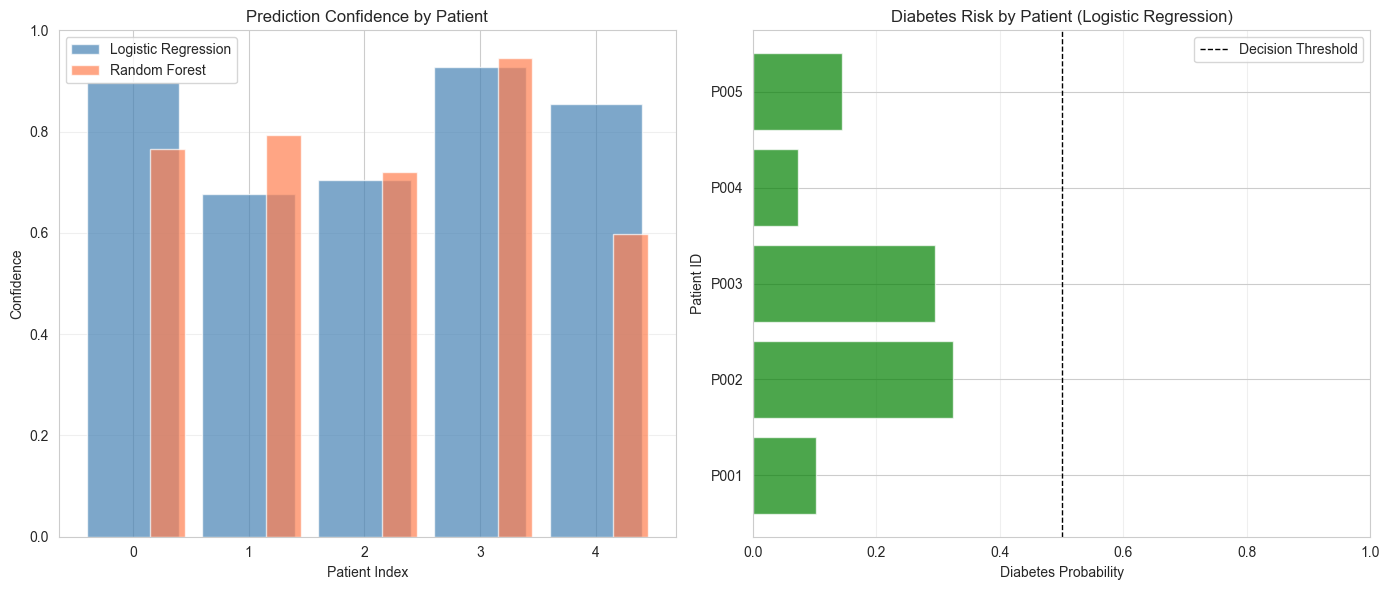

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Confidence levels by patient
ax1 = axes[0]
x = range(len(df_predictions_lr))
ax1.bar(x, df_predictions_lr['confidence'], alpha=0.7, label='Logistic Regression', color='steelblue')
if df_predictions_rf is not None:
    ax1.bar([i+0.3 for i in x], df_predictions_rf['confidence'], alpha=0.7, label='Random Forest', color='coral', width=0.3)
ax1.set_xlabel('Patient Index')
ax1.set_ylabel('Confidence')
ax1.set_title('Prediction Confidence by Patient')
ax1.legend()
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Probability distribution
ax2 = axes[1]
diabetes_probs = df_predictions_lr['probability_diabetes']
colors = ['green' if p < 0.5 else 'red' for p in diabetes_probs]
ax2.barh(df_predictions_lr['patient_id'], diabetes_probs, color=colors, alpha=0.7)
ax2.set_xlabel('Diabetes Probability')
ax2.set_ylabel('Patient ID')
ax2.set_title('Diabetes Risk by Patient (Logistic Regression)')
ax2.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='Decision Threshold')
ax2.legend()
ax2.set_xlim([0, 1])
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
#plt.savefig(f'predictions_visualization_{timestamp}.png', dpi=300, bbox_inches='tight')
#print(f"✅ Visualization saved to: predictions_visualization_{timestamp}.png")
plt.show()

## 10. Load and Predict from CSV File

In [11]:
def predict_from_csv(csv_file, model="logreg"):
    """
    Load patient data from CSV and get predictions
    
    Parameters:
    -----------
    csv_file : str
        Path to CSV file with patient data
    model : str
        Model to use ('logreg' or 'rf')
        
    Returns:
    --------
    DataFrame : Predictions results
    """
    try:
        # Load CSV
        df = pd.read_csv(csv_file)
        print(f"Loaded {len(df)} patients from {csv_file}")
        
        # Convert to list of dictionaries
        patients_list = df.to_dict('records')
        
        # Get predictions
        df_results = get_batch_predictions(patients_list, model=model)
        
        return df_results
        
    except FileNotFoundError:
        print(f"❌ File not found: {csv_file}")
        return None
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Example: Save sample data and reload it
sample_csv = "sample_patients.csv"
df_patients.to_csv(sample_csv, index=False)
print(f"Saved sample data to: {sample_csv}\n")

# Load and predict
print("Testing CSV loading functionality...\n")
df_from_csv = predict_from_csv(sample_csv, model="logreg")

if df_from_csv is not None:
    print("\n✅ Successfully loaded and predicted from CSV!\n")
    display(df_from_csv.head())

Saved sample data to: sample_patients.csv

Testing CSV loading functionality...

Loaded 5 patients from sample_patients.csv

✅ Successfully loaded and predicted from CSV!


✅ Successfully loaded and predicted from CSV!



,patient_id,patient_name,age,height,weight,bmi,prediction_class,prediction_label,probability_no_diabetes,probability_diabetes,confidence,model_used,timestamp
0,P001,Healthy Adult,45,175,70,22.86,0,No Diabetes,0.8975,0.1025,0.8975,Logistic Regression,2025-11-08 15:10:30
1,P002,Elderly Patient,72,168,85,30.12,0,No Diabetes,0.6762,0.3238,0.6762,Logistic Regression,2025-11-08 15:10:30
2,P003,High Risk Patient,68,165,90,33.06,0,No Diabetes,0.7043,0.2957,0.7043,Logistic Regression,2025-11-08 15:10:30
3,P004,Young Adult,28,170,65,22.49,0,No Diabetes,0.9277,0.0723,0.9277,Logistic Regression,2025-11-08 15:10:30
4,P005,Middle Age with Comorbidity,55,172,82,27.72,0,No Diabetes,0.8552,0.1448,0.8552,Logistic Regression,2025-11-08 15:10:30


## Summary

This notebook demonstrated:

✅ **Connecting to the FastAPI server**
- Health checks and status verification

✅ **Making predictions**
- Single patient predictions
- Batch predictions for multiple patients

✅ **Exporting to DataFrames**
- Structured results with patient information
- Prediction probabilities and confidence scores

✅ **Model comparison**
- Logistic Regression vs Random Forest
- Agreement rates and confidence levels

✅ **Data export**
- CSV files with timestamps
- Visualization of results

✅ **CSV integration**
- Load patient data from CSV files
- Batch process and export results

### Next Steps:
1. Load your own patient data from CSV files
2. Customize the feature selection
3. Add more visualization options
4. Integrate with your data pipeline
5. Schedule automated predictions